In [1]:
'''
Zé Fonseca

21/01/16

Notes: Data sets are classes and cases inside each dataset is a subclass

This ipython notebook simulates the data, has diferent log likelyhoods for the MCMC on top of the MCMC. 
Also has plot functions.  
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
import sys
from copy import deepcopy

%matplotlib inline

#### Part 1

## Simulating data

### Cases:
* 1: N_SNeIa=1000, z-[0.015,1.0], \sigma_mu=0.2 (both in the distribution and in the error bar), no z scatter;
* 2.1: z scatter=0.04*(1+z) but all z are positive 
* 2.2: z scatter=0.04*(1+z) only for z>0.1 (bellow we expect to have spectroscopic info)
* 3: 9% of the z are wrong (but we don't know which ones), on avarage Delta_z\sim 0.1

Note that for now error bars on mu will be given by 0.2. Error propagation in quadrature will be done later.

In [2]:
#cosmological functions
#general functions
def H(z,OM,H0,w):
    if w==-1:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM))
    else:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))

c=2.99792e5

def dL(z,OM,H0,w):
    return (1+z)*quad(lambda x:c/H(x,OM,H0,w),0,z)[0]

def mu(z,OM,H0,w):
    return 5*sp.log10(dL(z,OM,H0,w))+25

def dmudz_milne(z):
    return 10/np.log(10)*(1+z)/z/(z+2)

#class fake data with all the cases.

class fkd:
    def __init__(self,name,N=1000,z_min=0.015,z_max=1.0,OM=0.31,H0=67.74,w=-1,sig_mu=0.2):
        #parameters used
        self.N=N
        self.z_min=z_min
        self.z_max=z_max
        self.OM=OM
        self.H0=H0
        self.w=w
        self.dataset=name


        #get redshifts
        z=np.random.rand(N)*(z_max-z_min)+z_min
        z.sort()
        self.z=z
        
        #get magnitudes
        mu_t=np.array([mu(zi,OM,H0,w) for zi in z])
        mu_o=mu_t+np.random.randn(N)*sig_mu
        self.mu_t=mu_t
        self.mu_o=mu_o
        self.sig_mu=sig_mu
        
    class case21(object):
        pass
    
    class case22(object):
        pass
    
    class case3(object):
        pass
    
    def bias_sets_case21(self,error_z21=0.04):
        z_b21=np.zeros(len(self.z))
        for i in range(len(self.z)):
            z_b21[i]=self.z[i]+np.random.randn()*error_z21*(1+self.z[i])
            while z_b21[i]<=0:
                z_b21[i]=self.z[i]+np.random.randn()*error_z21*(1+self.z[i])
        
        self.case21.z=z_b21
        self.case21.mu_o=self.mu_o
        self.case21.sig_mu=self.sig_mu
        #mu error will be changed in MCMC
        self.case21.err_z=error_z21
        self.case21.cor=np.ones(self.N)
        
        self.case21.sig_milne2=self.sig_mu**2+(dmudz_milne(z_b21)*error_z21*(1+z_b21))**2
        
        self.case21.dataset=self.dataset+'_case21'
                
    def bias_sets_case22(self,error_z22=0.04):
        #case is the same as case 2.1 but with the original z<0.1 unchanged
        z_b22=deepcopy(self.case21.z)
        index=np.argwhere(self.z<=0.1)
        z_b22[index]=self.z[index]
                    
        self.case22.z=z_b22
        self.case22.mu_o=self.mu_o
        self.case22.err_z=error_z22
        self.case22.sig_mu=self.sig_mu
        index2=np.argwhere(z_b22<0.1)
        self.case22.cor=np.ones(self.N)
        self.case22.cor[index2]=0
        
        self.case22.sig_milne2=self.sig_mu**2+(dmudz_milne(z_b22)*error_z22*(1+z_b22)*self.case22.cor)**2
        
        self.case22.dataset=self.dataset+'_case22'
    
    def bias_sets_case3(self,dz_3=0.1,pgamma=0.91):
        
        z_b3=np.zeros(len(self.z))
        #second possible galaxy
        z_b3_2=np.zeros(len(self.z))
        for i in range(len(self.z)):
            if self.z[i]<=0.1:
                z_b3[i]=self.z[i]
                z_b3_2[i]=self.z[i]
            else:
                pvalue=np.random.rand()
                if pvalue>0.09:
                    z_b3[i]=self.z[i]
                    z_b3_2[i]=self.z[i]+np.random.randn()*dz_3
                    while z_b3_2[i]<=0:
                        z_b3_2[i]=self.z[i]+np.random.randn()*dz_3
                else:
                    z_b3[i]=self.z[i]+np.random.randn()*dz_3
                    z_b3_2[i]=self.z[i]
                    while z_b3[i]<=0:
                        z_b3[i]=self.z[i]+np.random.randn()*dz_3
                    
        
        self.case3.z=z_b3
        self.case3.z2=z_b3_2
        self.case3.mu_o=self.mu_o
        self.case3.dz=dz_3
        self.case3.sig_mu=self.sig_mu
        self.case3.pgamma=pgamma
        self.case3.dataset=self.dataset+'_case3'
        
    def get_case_data(self,filename,case,sig_mu=0.2,err_z=0.04,pgamma=0.91):
        
        dados=np.loadtxt(filename)
        
        if case==1:
            self.z=dados[:,0]
            self.mu_o=dados[:,1]
            self.sig_mu=sig_mu
            
        if case==21:
            self.case21.z=dados[:,0]
            self.case21.mu_o=dados[:,1]
            self.case21.err_z=err_z
            self.case21.sig_mu=sig_mu
            self.case21.cor=np.ones(len(dados[:,0]))
            self.case21.sig_milne2=sig_mu**2+(dmudz_milne(dados[:,0])*err_z*(1+dados[:,0]))**2
            
        if case==22:
            self.case22.z=dados[:,0]
            self.case22.mu_o=dados[:,1]
            self.case22.err_z=err_z
            self.case22.sig_mu=sig_mu
            
            index2=np.argwhere(dados[:,0]<0.1)
            self.case22.cor=np.ones(len(dados[:,0]))
            self.case22.cor[index2]=0
            
            self.case22.sig_milne2=sig_mu**2+(dmudz_milne(dados[:,0])*err_z*(1+dados[:,0])*self.case22.cor)**2
            
        if case==3:
            self.case3.z=dados[:,0]
            self.case3.z2=dados[:,1]
            self.case3.mu_o=dados[:,2]
            self.case3.sig_mu=sig_mu
            self.case3.pgamma=pgamma
            
    
def get_case_chain(data,filename,subcase=False):
    dados=np.loadtxt(filename)
    
    if subcase=='b':
        data.milne_chain_o_m=dados[:,0]
        data.milne_chain_w=dados[:,1]
        data.milne_chain_H0=dados[:,2]
        data.milne_log_like=dados[:,3]
    elif subcase=='c':
        data.zn_chain_o_m=dados[:,0]
        data.zn_chain_w=dados[:,1]
        data.zn_chain_H0=dados[:,2]
        data.zn_log_like=dados[:,3]
    else:
        data.chain_o_m=dados[:,0]
        data.chain_w=dados[:,1]
        data.chain_H0=dados[:,2]
        data.log_like=dados[:,3]
            
            
        

In [3]:
#initiate data and simulate it
fd=fkd('fd4')

#In this case the data will be loaded
fd.bias_sets_case21()
fd.bias_sets_case22()
fd.bias_sets_case3()

#we load it instead
#fd3.get_case_data('data_fd3_case1_zf.txt',1)
#fd3.get_case_data('data_fd3_case21_zf.txt',21)
#fd3.get_case_data('data_fd3_case22_zf.txt',22)
#fd3.get_case_data('data_fd3_case3_zf.txt',3)
#get_case_chain(fd.case21,'mcmc_fd3_case21_znoise_zf.txt','c')

In [4]:
# save data and plot it

def save_sim_data(data):
    #case1
    np.savetxt('data_'+data.dataset+'_case1_zf.txt',np.c_[data.z,data.mu_o],fmt='%2.3f',\
           header='\n'.join(["Error in mu %.2f" %data.sig_mu,"z   mu"]))
    #case21
    np.savetxt('data_'+data.dataset+'_case21_zf.txt',np.c_[data.case21.z,data.case21.mu_o],fmt='%2.3f',\
           header='\n'.join(["Error in mu %.2f" %data.case21.sig_mu,"Photo-z Error %.3f" %data.case21.err_z,"z   mu"]))
    #case22
    np.savetxt('data_'+data.dataset+'_case22_zf.txt',np.c_[data.case22.z,data.case22.mu_o],fmt='%2.3f',\
           header='\n'.join(["Error in mu %.2f" %data.case22.sig_mu,"Photo-z Error %.3f" %data.case22.err_z,"z   mu"]))
    #case3
    np.savetxt('data_'+data.dataset+'_case3_zf.txt',np.c_[data.case3.z,data.case3.z2,data.case3.mu_o],fmt='%2.3f',\
           header='\n'.join(["Error in mu %.2f" %data.case3.sig_mu,"Average sig_z %.2f" %data.case3.dz, "z   z2   mu"]))

In [5]:
save_sim_data(fd)

In [6]:
def plt_allcases(data):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[1,1],'height_ratios':[1,1]})
    
    axarr[0,0].errorbar(data.z,data.mu_o,yerr=[data.sig_mu*np.ones(data.N),data.sig_mu*np.ones(data.N)],fmt='ko')
    axarr[0,0].plot(data.z,data.mu_t,'r')
    axarr[0,0].set_xlabel(r'$z$')
    axarr[0,0].set_ylabel(r'$\mu$')
    axarr[0,0].set_title('Case 1')
    
    axarr[0,1].errorbar(data.case21.z,data.case21.mu_o,yerr=[data.case21.sig_mu*np.ones(data.N),data.case21.sig_mu*np.ones(data.N)],fmt='bo')
    axarr[0,1].plot(data.z,data.mu_t,'r')
    axarr[0,1].set_ylabel(r'$z$')
    axarr[0,1].set_xlabel(r'$\mu$')
    axarr[0,1].set_title('Case 21')
    
    axarr[1,0].errorbar(data.case22.z,data.case22.mu_o,yerr=[data.case22.sig_mu*np.ones(data.N),data.case22.sig_mu*np.ones(data.N)],fmt='bs')
    axarr[1,0].plot(data.z,data.mu_t,'r')
    axarr[1,0].set_ylabel(r'$z$')
    axarr[1,0].set_xlabel(r'$\mu$')
    axarr[1,0].set_title('Case 22')   
    
    axarr[1,1].errorbar(data.case3.z,data.case3.mu_o,yerr=[data.case3.sig_mu*np.ones(data.N),data.case3.sig_mu*np.ones(data.N)],fmt='g^')
    axarr[1,1].plot(data.z,data.mu_t,'r')
    axarr[1,1].set_ylabel(r'$z$')
    axarr[1,1].set_xlabel(r'$\mu$')
    axarr[1,1].set_title('Case 3') 
    
    plt.savefig('datasets_allcases_'+data.dataset+'_zf.pdf')
    plt.show()

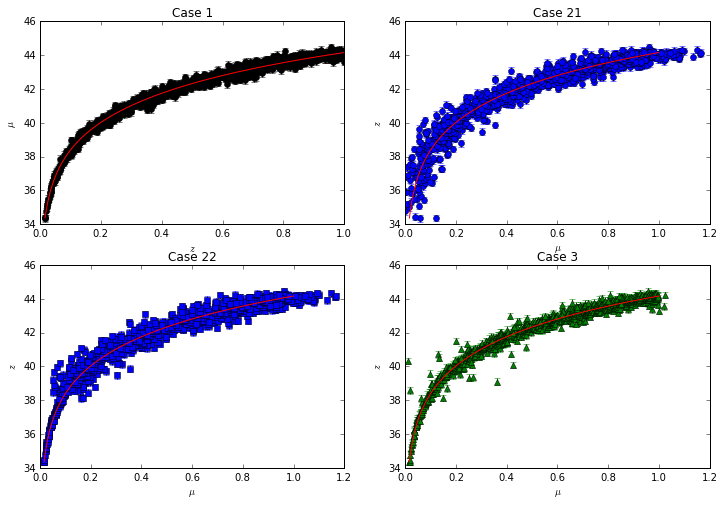

In [7]:
plt_allcases(fd)

# Part 2

## Do the MCMC to the data

Notes: when adding errors in MCMC we need 3 different error adding. Case 3 does not have mu errors increased in quadrature. 

In [8]:
# Functions
def interpoler_mu(OM,H0,w,z_data):
    z_spl = np.linspace(min(z_data), max(z_data),100)
    mu_spl = np.array([mu(z_spli,OM,H0,w) for z_spli in z_spl])
    mu_spl_rep = splrep(z_spl, mu_spl)
    mu_theory=splev(z_data, mu_spl_rep)
    return mu_theory

#MCMC priors
def prior_om(x):
    if x>=0 and x<=1:
        return 1
    else:
        return 0
    
def prior_w(x):
    if x>=-6 and x<=4:
        return 1
    else:
        return 0
    
def prior_H0(x):
    if x>=10 and x<=200:
        return 1
    else:
        return 0
    
def chi2(mu_o,mu_t,sigma2):
    return (mu_o-mu_t)**2/sigma2
    
def dmudz(z,mu,OM=0.31,H0=67.74,w=-1):
    return 5/np.log(10)*(1/(1+z)+(1+z)*c/(H(z,OM,H0,w)*10**(mu/5-5)))



In [9]:
def log_like_fixsig(data,om,H0,w):
    mu_t=interpoler_mu(om,H0,w,data.z)
    return -chi2(data.mu_o,mu_t,data.sig_mu**2)/2

def log_like_varsig(data,om,H0,w):
    mu_t=interpoler_mu(om,H0,w,data.z)
    sigma2=data.sig_mu**2+(dmudz(data.z,mu_t,om,H0,w)*data.err_z*(1+data.z)*data.cor)**2
    return -(chi2(data.mu_o,mu_t,sigma2)/2+np.log(sigma2))

def log_like_milne(data,om,H0,w):
    mu_t=interpoler_mu(om,H0,w,data.z)
    return -chi2(data.mu_o,mu_t,data.sig_milne2)/2

def log_like_2gal(data,om,H0,w):
    mu_t1=interpoler_mu(om,H0,w,data.z)
    mu_t2=interpoler_mu(om,H0,w,data.z2)
    return np.log(data.pgamma*np.exp(-chi2(data.mu_o,mu_t1,data.sig_mu**2)/2)+\
                  (1-data.pgamma)*np.exp(-chi2(data.mu_o,mu_t2,data.sig_mu**2)/2))


In [31]:
def MCMC_SNe(N,data,loglike_func):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    log_like=np.zeros(N)
    
    #set starting point
    o_m[0]=np.random.rand()*0.1+0.25
    w[0]=np.random.rand()*0.2-1.1
    H0[0]=np.random.rand()*5+65
    log_like[0]=sum(loglike_func(data,o_m[0],H0[0],w[0]))
    
    #dummy var for acceptance rate
    naccept=0
    for i in range(N-1):
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1]=log_like[i]
            naccept+=1
            next
        else:
            #compute new log_like
            log_like[i+1]=sum(loglike_func(data,o_m[i+1],H0[i+1],w[i+1]))
            #if priors not flat they need to be included after the exp. for now flat prior
            r=sp.exp(log_like[i+1]-log_like[i])
            #accept or not
            teste=np.random.rand()
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1]=log_like[i]
                naccept+=1
                next
                
        #really cool piece of code from Ethan
        inc100 = np.int64(i/(N-2)*100)
        inc50 = np.int64(i/(N-2)*50)
        sys.stdout.write('\r')
        sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
        sys.stdout.flush()
        
    acceptr=(N-naccept)/N*100
    
    data.nsteps=N
    
    if loglike_func==log_like_varsig:
        data.zn_chain_o_m=o_m
        data.zn_chain_w=w
        data.zn_chain_H0=H0
        data.zn_log_like=log_like
        data.zn_acceptr=acceptr
    elif loglike_func==log_like_milne:
        data.milne_chain_o_m=o_m
        data.milne_chain_w=w
        data.milne_chain_H0=H0
        data.milne_log_like=log_like
        data.milne_acceptr=acceptr
    elif loglike_func==log_like_2gal:
        data.unb3_chain_o_m=o_m
        data.unb3_chain_w=w
        data.unb3_chain_H0=H0
        data.unb3_log_like=log_like
        data.unb3_acceptr=acceptr
    else:
        data.chain_o_m=o_m
        data.chain_w=w
        data.chain_H0=H0
        data.log_like=log_like
        data.acceptr=acceptr

## Make plots

In [38]:
def plot_sct_hist(data1,data2,z_noise=False,milne=False,z_2gal=False,burn_tail=500,thining=1,nb=20):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    if z_noise==True:
        title=data2.dataset+' with photometric error propagation in quadrature'
        caset=data2.dataset+'_zn'
        om2=data2.zn_chain_o_m[burn_tail::thining]
        w2=data2.zn_chain_w[burn_tail::thining]
        H02=data2.zn_chain_H0[burn_tail::thining]
    elif milne==True:
        title=data2.dataset+' with photometric error propagation as in Milne'
        caset=data2.dataset+'_milne'
        om2=data2.milne_chain_o_m[burn_tail::thining]
        w2=data2.milne_chain_w[burn_tail::thining]
        H02=data2.milne_chain_H0[burn_tail::thining]  
    elif z_2gal==True:
        title=data2.dataset+' with case 3 unbiased'
        caset=data2.dataset+'_2gal'
        om2=data2.unb3_chain_o_m[burn_tail::thining]
        w2=data2.unb3_chain_w[burn_tail::thining]
        H02=data2.unb3_chain_H0[burn_tail::thining]
    else:
        title=data2.dataset
        caset=data2.dataset
        om2=data2.chain_o_m[burn_tail::thining]
        w2=data2.chain_w[burn_tail::thining]
        H02=data2.chain_H0[burn_tail::thining]
        
    
    f.text(0.5, 0.95, 'Bias: '+title,horizontalalignment='center',verticalalignment='top')
    
    om_min=min(np.amin(data1.chain_o_m[burn_tail::thining]),np.amin(om2))
    om_max=max(np.amax(data1.chain_o_m[burn_tail::thining]),np.amax(om2))
    
    w_min=min(np.amin(data1.chain_w[burn_tail::thining]),np.amin(w2))
    w_max=max(np.amax(data1.chain_w[burn_tail::thining]),np.amax(w2))
    
    H0_min=min(np.amin(data1.chain_H0[burn_tail::thining]),np.amin(H02))
    H0_max=max(np.amax(data1.chain_H0[burn_tail::thining]),np.amax(H02))
    
    axarr[0,0].hist(data1.chain_o_m[burn_tail::thining],color='r',bins=nb,alpha=0.2)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].hist(om2,color='b',bins=nb,alpha=0.2)
    
    axarr[1,0].scatter(data1.chain_o_m[burn_tail::thining],data1.chain_w[burn_tail::thining],color='r',alpha=0.05)
    axarr[1,0].scatter(om2,w2,color='b',alpha=0.05)
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    
    axarr[0,1].hist(data1.chain_H0[burn_tail::thining],bins=nb,color='r',alpha=0.2)
    axarr[0,1].hist(H02,bins=nb,color='b',alpha=0.2)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    axarr[1,1].hist(data1.chain_w[burn_tail::thining],bins=nb,color='r',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].hist(w2,bins=nb,color='b',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    
    plt.savefig('bias_sct_'+caset+'_zf.pdf')
    
    plt.show()


def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

def plot_contour_hist(data1,data2,z_noise=False,milne=False,z_2gal=False,burn_tail=500,thining=1,nb=20):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    
    
    Hist_mcmc, omedges,wedges = np.histogram2d(data1.chain_o_m[burn_tail::thining],data1.chain_w[burn_tail::thining],bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Neff=len(data1.chain_o_m[burn_tail::thining])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Neff)
    #plt.plot(om_max,w_max,'rx',ms=10)
    
    bins_om=[round(x*0.025,3) for x in range(0,40)]
    bins_w=[round(x*0.05-5,3) for x in range(0,120)]
    bins_H=[x*0.25+50 for x in range(0,120)]
    
    if z_noise==True:
        title=data2.dataset+' with photometric error propagation in quadrature'
        caset=data2.dataset+'_zn'
        om2=data2.zn_chain_o_m[burn_tail::thining]
        w2=data2.zn_chain_w[burn_tail::thining]
        H02=data2.zn_chain_H0[burn_tail::thining]
    elif milne==True:
        title=data2.dataset+' with photometric error propagation as in Milne'
        caset=data2.dataset+'_milne'
        om2=data2.milne_chain_o_m[burn_tail::thining]
        w2=data2.milne_chain_w[burn_tail::thining]
        H02=data2.milne_chain_H0[burn_tail::thining]
    elif z_2gal==True:
        title=data2.dataset+' with case 3 unbiased'
        caset=data2.dataset+'_2gal'
        om2=data2.unb3_chain_o_m[burn_tail::thining]
        w2=data2.unb3_chain_w[burn_tail::thining]
        H02=data2.unb3_chain_H0[burn_tail::thining]
    else:
        title=data2.dataset
        caset=data2.dataset
        om2=data2.chain_o_m[burn_tail::thining]
        w2=data2.chain_w[burn_tail::thining]
        H02=data2.chain_H0[burn_tail::thining]
        
    Hist_mcmc2, omedges2,wedges2 = np.histogram2d(om2,w2,bins=(nb, nb))
    om_c2=np.array([(omedges2[i]+omedges2[i+1])/2 for i in range(len(omedges2)-1)])
    w_c2=np.array([(wedges2[i]+wedges2[i+1])/2 for i in range(len(wedges2)-1)])
    Neff2=len(om2)
    Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)
    
    f.text(0.5, 0.95, 'Bias: '+title,horizontalalignment='center',verticalalignment='top')
    
    om_min=min(np.amin(data1.chain_o_m[burn_tail::thining]),np.amin(om2))
    om_max=max(np.amax(data1.chain_o_m[burn_tail::thining]),np.amax(om2))
    
    w_min=min(np.amin(data1.chain_w[burn_tail::thining]),np.amin(w2))
    w_max=max(np.amax(data1.chain_w[burn_tail::thining]),np.amax(w2))
    
    H0_min=min(np.amin(data1.chain_H0[burn_tail::thining]),np.amin(H02))
    H0_max=max(np.amax(data1.chain_H0[burn_tail::thining]),np.amax(H02))
    
    axarr[0,0].hist(data1.chain_o_m[burn_tail::thining],color='r',bins=bins_om,alpha=0.2)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].hist(om2,color='b',bins=bins_om,alpha=0.2)
    
    import matplotlib as mpl
    colors1 = [(1.0, 0.0, 0.0, 0.7),(1.0, 0.0, 0.0, 0.4)] 
    cmap1 = mpl.colors.ListedColormap(colors1)
    colors2 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
    cmap2 = mpl.colors.ListedColormap(colors2)
    
    axarr[1,0].contourf(om_c,w_c, Hist_mcmc.T,levels=[N95,N68,Nmax], cmap=cmap1)
    axarr[1,0].contourf(om_c2,w_c2, Hist_mcmc2.T,levels=[N952,N682,Nmax2],cmap=cmap2)
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    
    axarr[0,1].hist(data1.chain_H0[burn_tail::thining],bins=bins_H,color='r',alpha=0.2)
    axarr[0,1].hist(H02,bins=bins_H,color='b',alpha=0.2)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    axarr[1,1].hist(data1.chain_w[burn_tail::thining],bins=bins_w,color='r',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].hist(w2,bins=bins_w,color='b',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    
    plt.savefig('bias_'+caset+'_zf.pdf')
    
    plt.show()
    
def plot_conv_mcmc(data,z_noise=False,milne=False,z_2gal=False,burn_tail=0,thining=1):
    
    f, axarr = plt.subplots(3,1,figsize=(8,12))
    
    if z_noise==True:
        title=data.dataset+' with photometric error propagation in quadrature'
        caset=data.dataset+'_zn'
        om=data.zn_chain_o_m[burn_tail::thining]
        w=data.zn_chain_w[burn_tail::thining]
        H0=data.zn_chain_H0[burn_tail::thining]
    elif milne==True:
        title=data.dataset+' with photometric error propagation as in Milne'
        caset=data.dataset+'_milne'
        om=data.milne_chain_o_m[burn_tail::thining]
        w=data.milne_chain_w[burn_tail::thining]
        H0=data.milne_chain_H0[burn_tail::thining]
    elif z_2gal==True:
        title=data.dataset+' with case 3 unbiased'
        caset=data.dataset+'_2gal'
        om=data.unb3_chain_o_m[burn_tail::thining]
        w=data.unb3_chain_w[burn_tail::thining]
        H0=data.unb3_chain_H0[burn_tail::thining]
    else:
        title=data.dataset
        caset=data.dataset
        om=data.chain_o_m[burn_tail::thining]
        w=data.chain_w[burn_tail::thining]
        H0=data.chain_H0[burn_tail::thining]
    
    f.text(0.5, 0.95,'Convergence: '+title,horizontalalignment='center',verticalalignment='top')
    
    axarr[0].plot(om)
    axarr[0].set_ylim([np.amin(om),np.amax(om)])
    axarr[0].set_ylabel(r'$\Omega_M$')
    
    axarr[1].plot(w)
    axarr[1].set_ylim([np.amin(w),np.amax(w)])
    axarr[1].set_ylabel(r'$w$')
    
    axarr[2].plot(H0)
    axarr[2].set_ylim([np.amin(H0),np.amax(H0)])
    axarr[2].set_ylabel(r'$H_0$')
    
    plt.setp(axarr[0].get_xticklabels(), visible=False)
    plt.setp(axarr[1].get_xticklabels(), visible=False)
    
    plt.savefig('convergence_'+caset+'_zf.pdf')
    plt.show()

# Run for dataset 

In [12]:
Nsteps=50000

In [13]:
# Do for the fake dataset 4

MCMC_SNe(Nsteps,fd,log_like_fixsig)
print('\n',fd.acceptr)

[##################################################]100%
 5.390000000000001


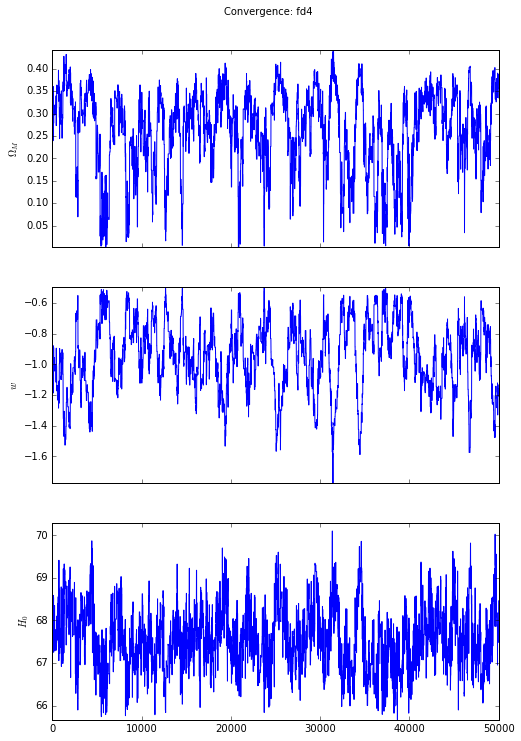

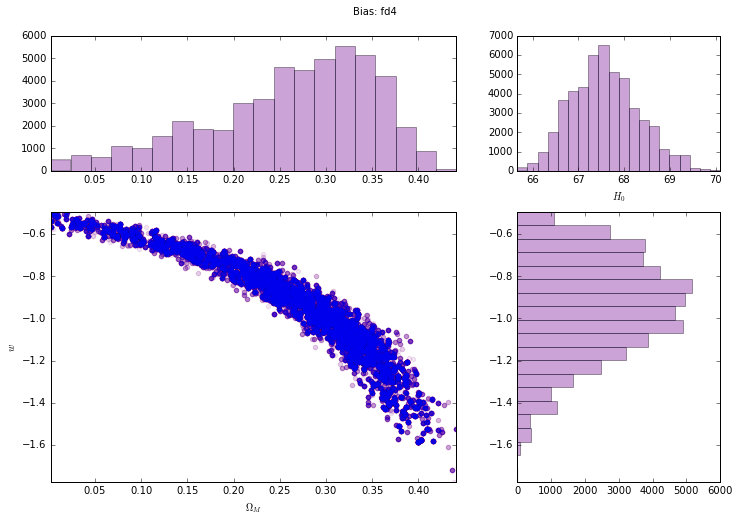

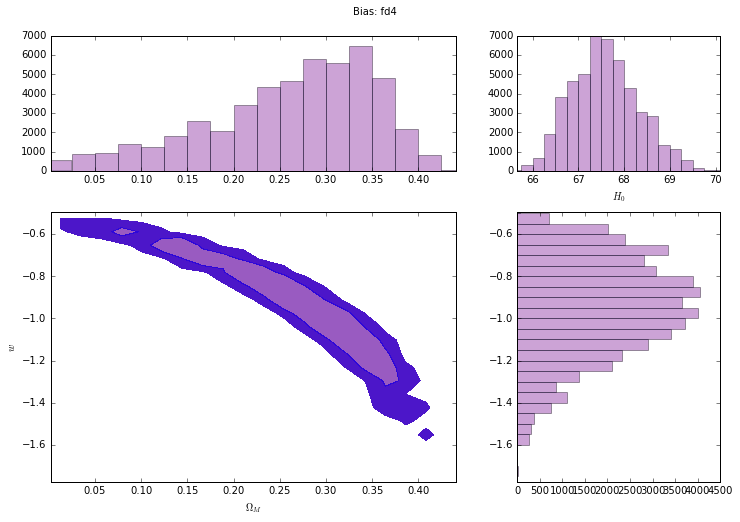

In [14]:
plot_conv_mcmc(fd,'fid')
plot_sct_hist(fd,fd,'fid')
plot_contour_hist(fd,fd,'fid')

In [33]:
def save_mcmc(data,z_noise=False,milne=False,z_2gal=False):
    if z_noise==True:
        np.savetxt('mcmc_'+data.dataset+'_c_zf.txt',np.c_[data.zn_chain_o_m,data.zn_chain_w,data.zn_chain_H0,data.zn_log_like],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3f'], header='\n'.join(["acceptance rate %.2f" %data.zn_acceptr,\
                                                                            "Om   w   H0   chi2"]))
    elif milne==True:
        np.savetxt('mcmc_'+data.dataset+'_b_zf.txt',np.c_[data.milne_chain_o_m,data.milne_chain_w,data.milne_chain_H0,data.milne_log_like],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3f'], header='\n'.join(["acceptance rate %.2f" %data.milne_acceptr,\
                                                                            "Om   w   H0   chi2"]))
    elif z_2gal==True:
        np.savetxt('mcmc_'+data.dataset+'_2gal_zf.txt',np.c_[data.unb3_chain_o_m,data.unb3_chain_w,data.unb3_chain_H0,data.unb3_log_like],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3f'], header='\n'.join(["acceptance rate %.2f" %data.unb3_acceptr,\
                                                                            "Om   w   H0   chi2"]))
    else:
        np.savetxt('mcmc_'+data.dataset+'_zf.txt',np.c_[data.chain_o_m,data.chain_w,data.chain_H0,data.log_like],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3f'],header='\n'.join(["acceptance rate %.2f" %data.acceptr,\
                                                                           "Om   w   H0   chi2"]))

In [15]:

save_mcmc(fd)
#save_mcmc(union21,'union21_case1')

## Run for other cases

In [16]:
MCMC_SNe(Nsteps,fd.case3,log_like_fixsig)
print('\n',fd.case3.acceptr)
save_mcmc(fd.case3)

[##################################################]100%
 4.868


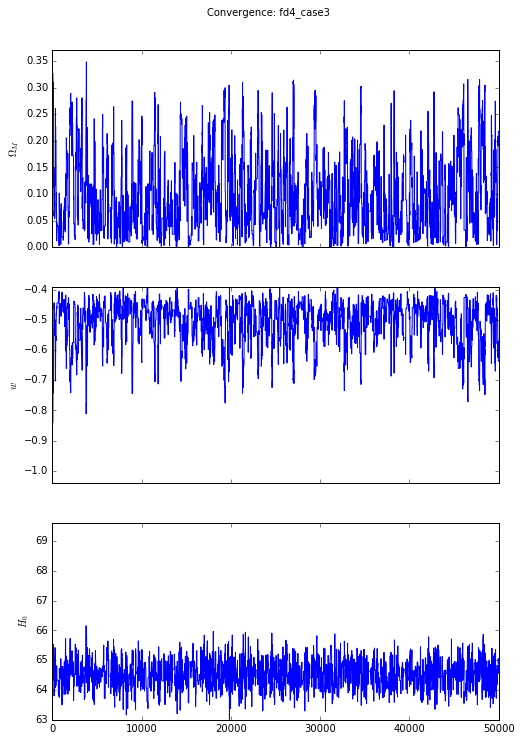

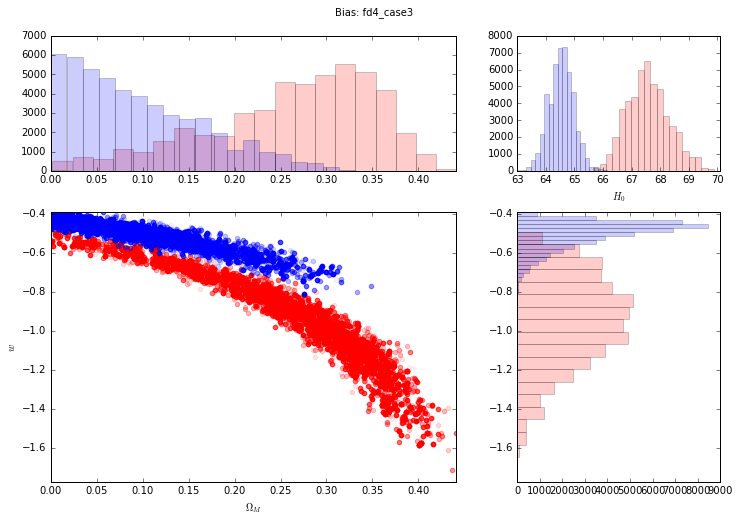

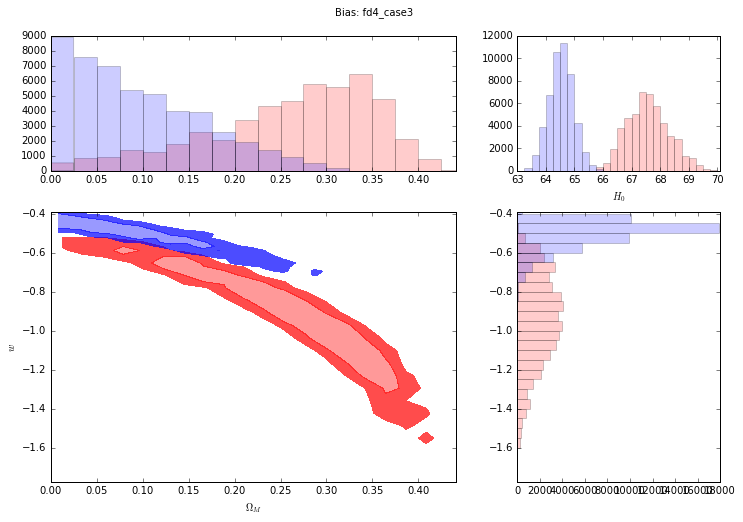

In [17]:
plot_conv_mcmc(fd.case3)
plot_sct_hist(fd,fd.case3)
plot_contour_hist(fd,fd.case3)

In [18]:
# 
MCMC_SNe(Nsteps,fd.case21,log_like_fixsig)
print('\n',fd.case21.acceptr)
save_mcmc(fd.case21)

[##################################################]100%
 8.522


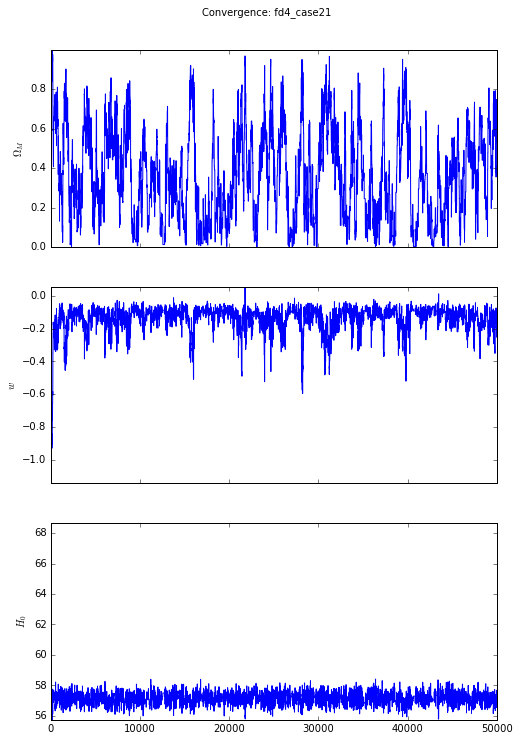

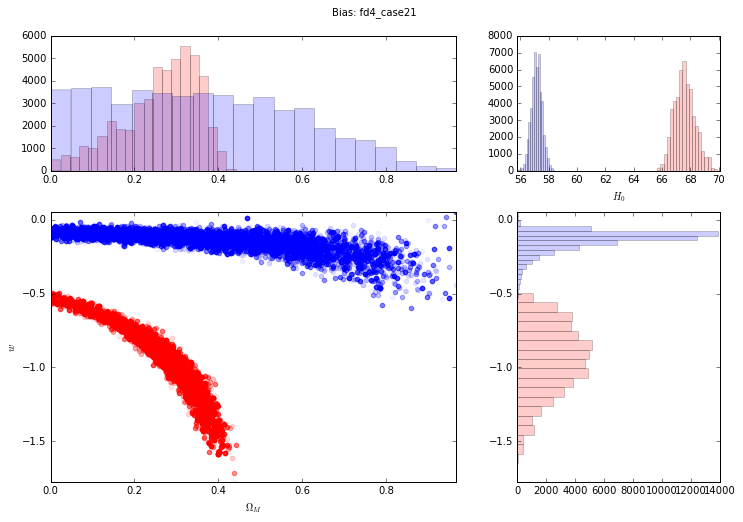

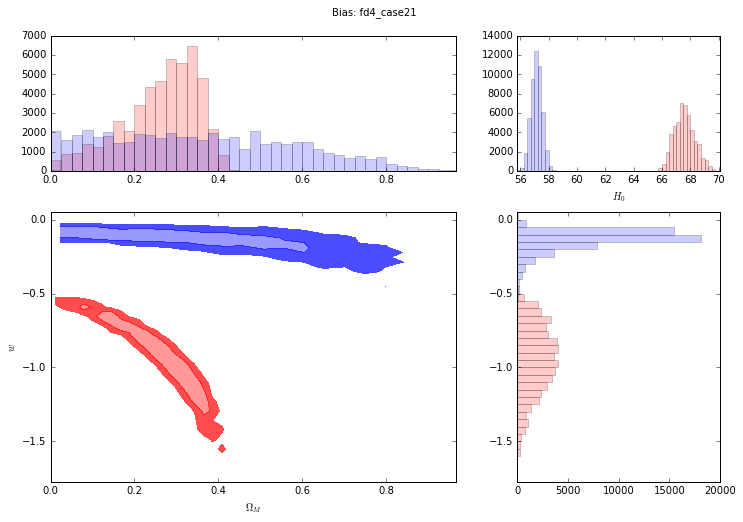

In [19]:
plot_conv_mcmc(fd.case21,)
plot_sct_hist(fd,fd.case21)
plot_contour_hist(fd,fd.case21)

In [20]:
MCMC_SNe(Nsteps,fd.case22,log_like_fixsig)
print('\n',fd.case22.acceptr)
save_mcmc(fd.case22)

[##################################################]100%
 7.62


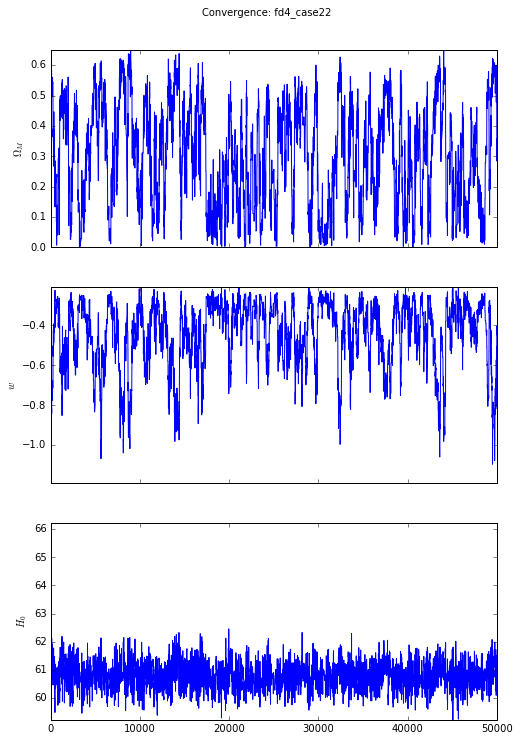

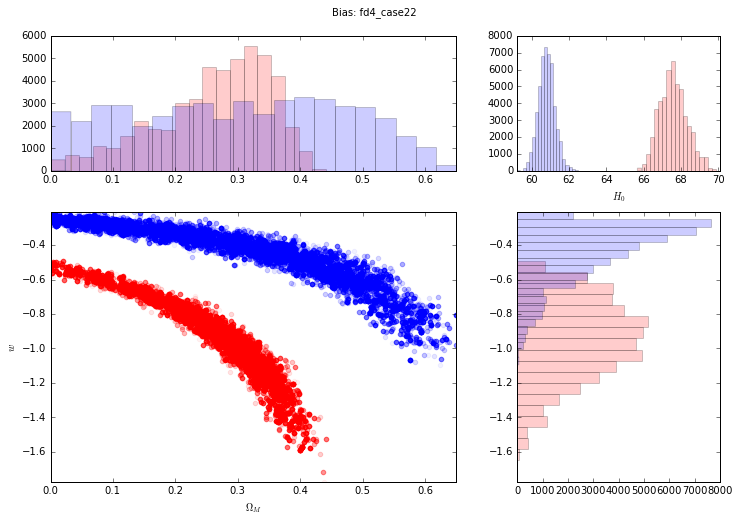

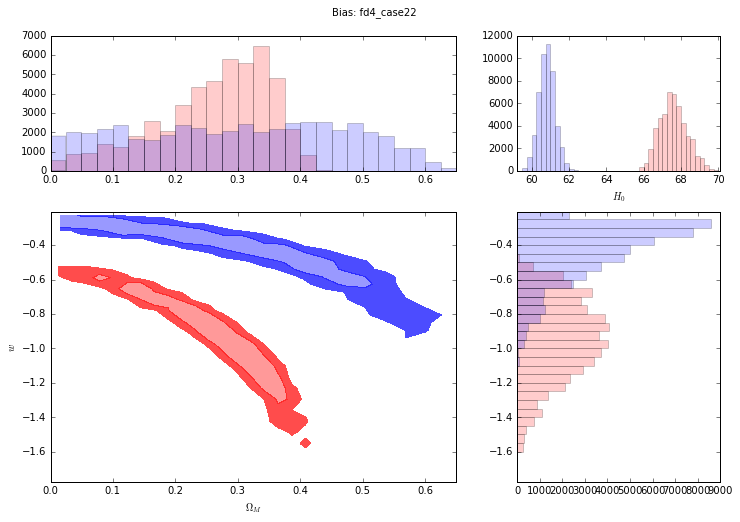

In [21]:
plot_conv_mcmc(fd.case22)
plot_sct_hist(fd,fd.case22)
plot_contour_hist(fd,fd.case22)

In [22]:
MCMC_SNe(Nsteps,fd.case21,log_like_milne)
print('\n',fd.case21.milne_acceptr)
save_mcmc(fd.case21,milne=True)

[##################################################]100%
 12.274000000000001


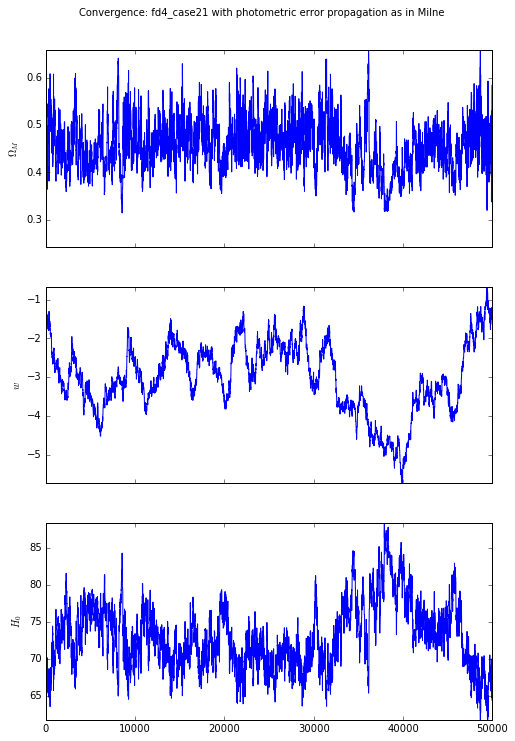

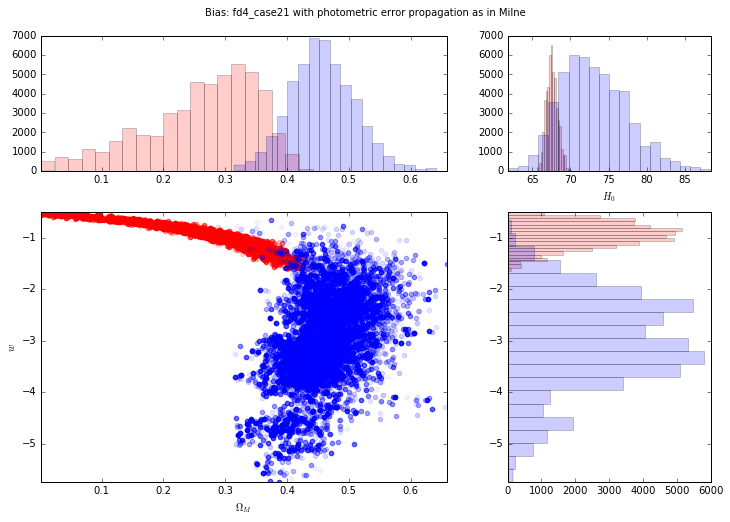

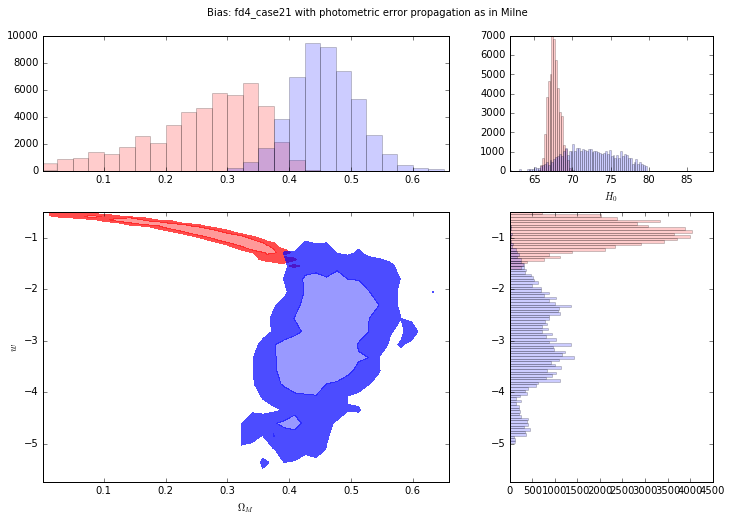

In [23]:
plot_conv_mcmc(fd.case21,milne=True)
plot_sct_hist(fd,fd.case21,milne=True)
plot_contour_hist(fd,fd.case21,milne=True)

In [24]:
MCMC_SNe(Nsteps,fd.case22,log_like_milne)
print('\n',fd.case22.milne_acceptr)
save_mcmc(fd.case22,milne=True)

[##################################################]100%
 14.932


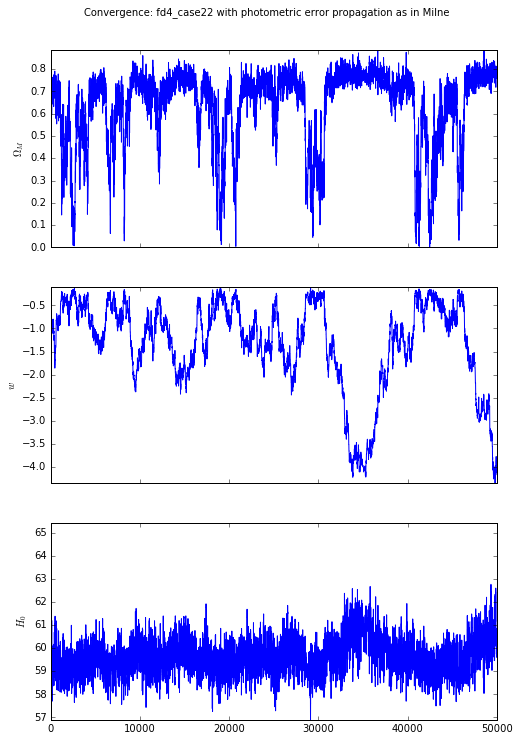

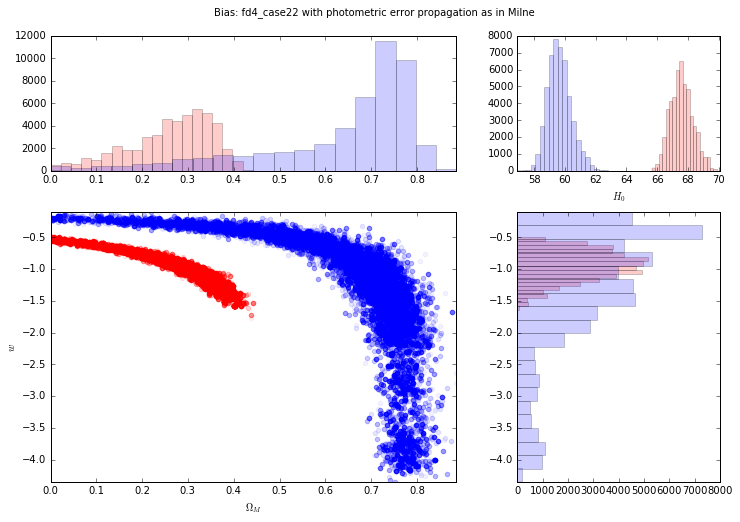

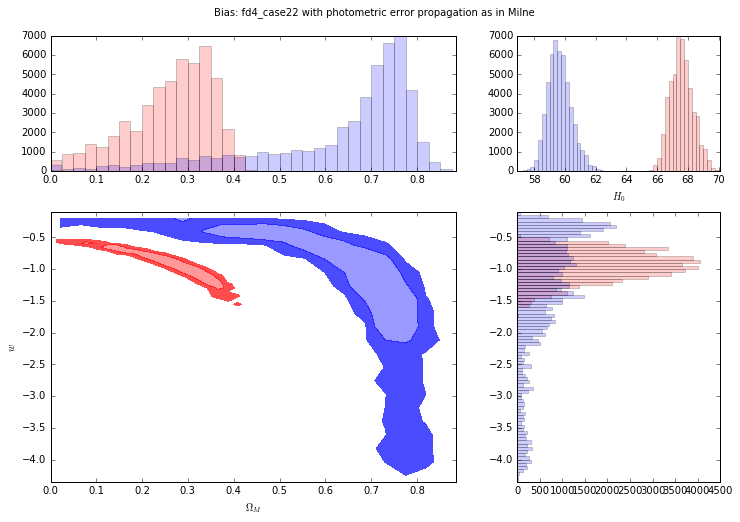

In [25]:
plot_conv_mcmc(fd.case22,milne=True)
plot_sct_hist(fd,fd.case22,milne=True)
plot_contour_hist(fd,fd.case22,milne=True)

In [26]:
#the other cases
MCMC_SNe(Nsteps,fd.case21,log_like_varsig)
print('\n',fd.case21.zn_acceptr)
save_mcmc(fd.case21,z_noise=True)

[##################################################]100%
 19.418


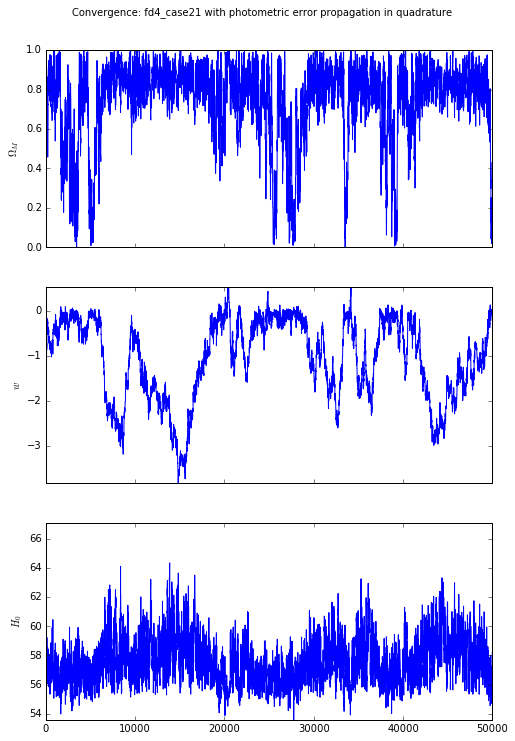

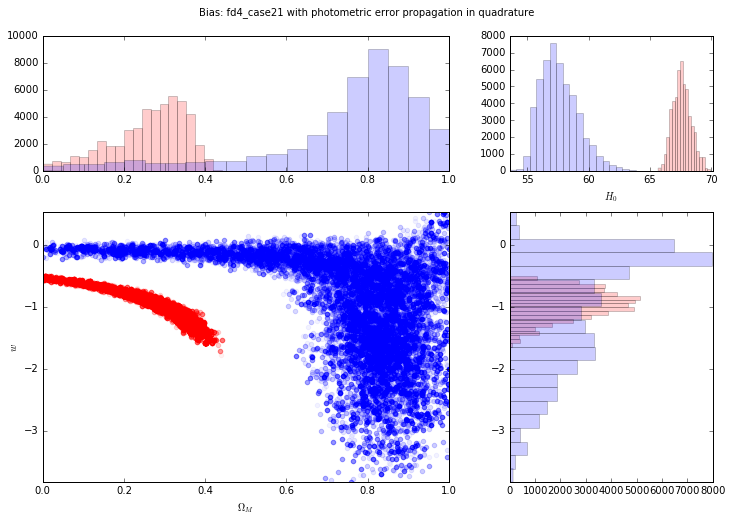

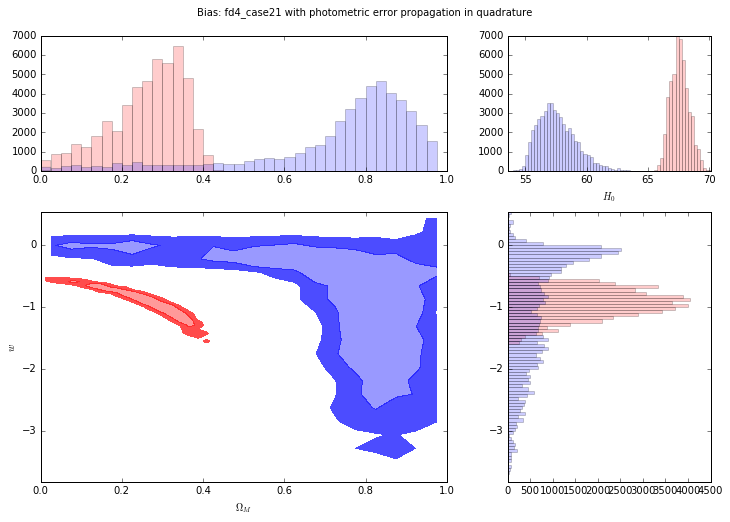

In [27]:
plot_conv_mcmc(fd.case21,z_noise=True)
plot_sct_hist(fd,fd.case21,z_noise=True)
plot_contour_hist(fd,fd.case21,z_noise=True)

In [28]:
MCMC_SNe(Nsteps,fd.case22,log_like_varsig)
print('\n',fd.case22.zn_acceptr)
save_mcmc(fd.case22,z_noise=True)

[##################################################]100%
 11.152


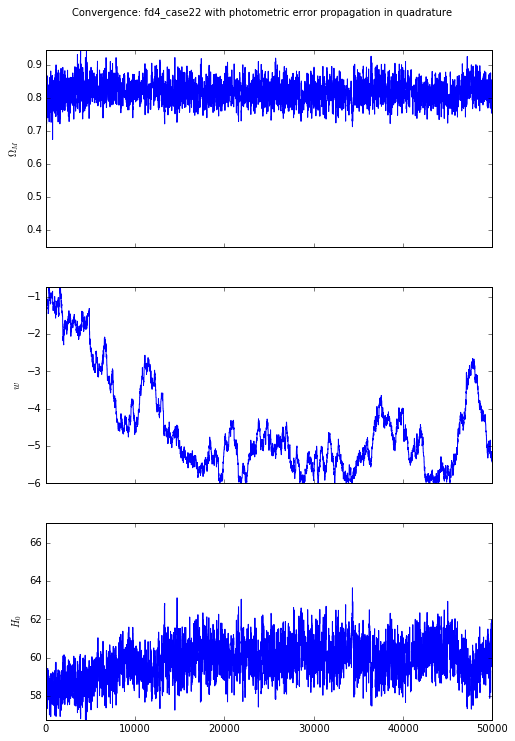

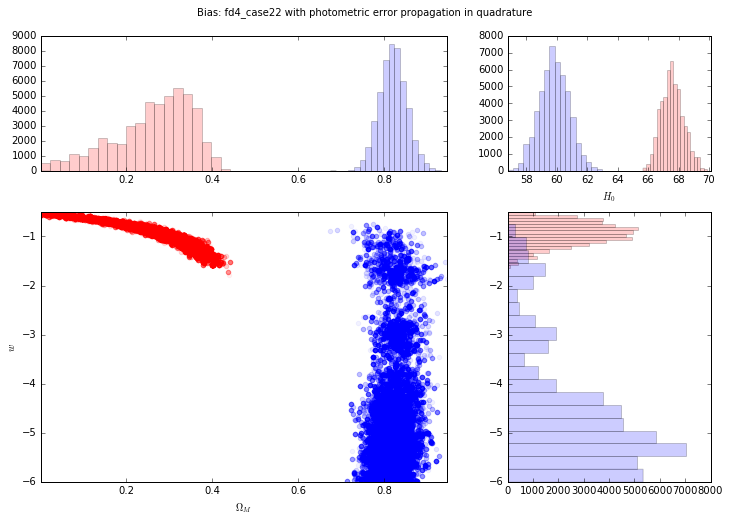

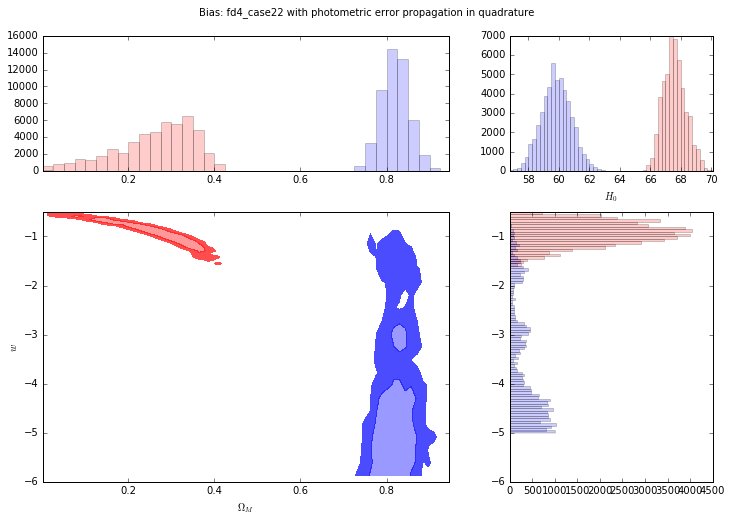

In [29]:
plot_conv_mcmc(fd.case22,z_noise=True)
plot_sct_hist(fd,fd.case22,z_noise=True)
plot_contour_hist(fd,fd.case22,z_noise=True)

In [34]:
#two gal
MCMC_SNe(Nsteps,fd.case3,log_like_2gal)
print('\n',fd.case3.unb3_acceptr)
save_mcmc(fd.case3,z_2gal=True)

[##################################################]100%
 5.804


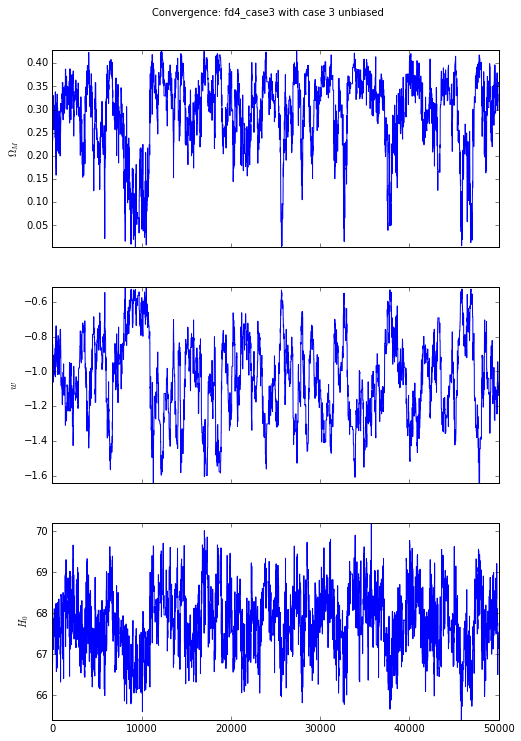

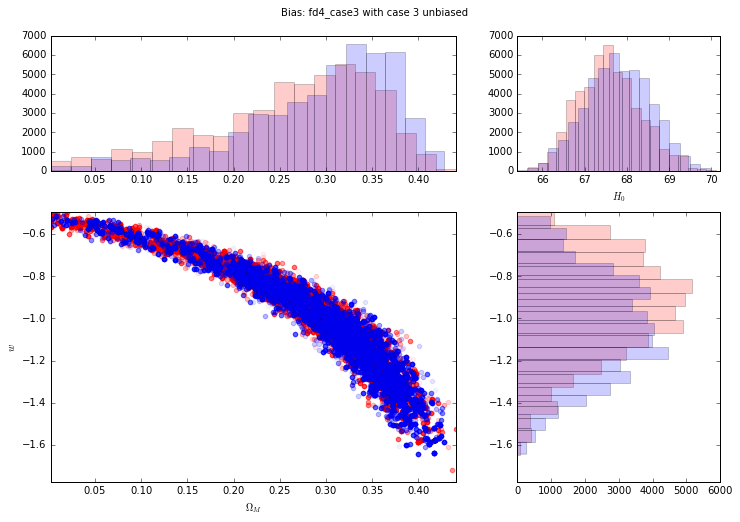

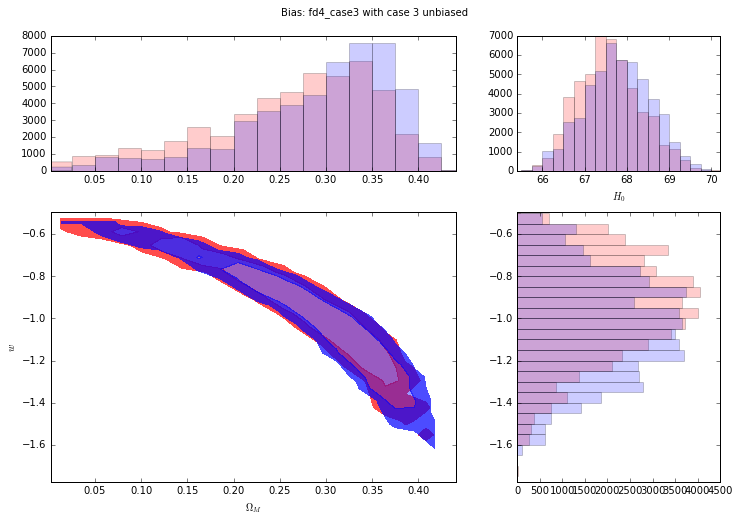

In [39]:
plot_conv_mcmc(fd.case3,z_2gal=True)
plot_sct_hist(fd,fd.case3,z_2gal=True)
plot_contour_hist(fd,fd.case3,z_2gal=True)